In [1]:
%reload_ext autoreload
%autoreload 2

# Analysis 101

To do:
- colour-code points by the distance from the mean pH to contextualise the magnitude of experimental change in pH
- amalgamate any studies with n=1 since need sd for hedges
- deal with temperature-only studies (not all studies have carbonate chemistry)
- plot 3d plot of temperature, ph,


In [10]:
### import
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# clustering
from sklearn.cluster import KMeans

# custom
# from calcification import analysis, utils, plotting
from calcification import analysis, utils, plotting, config

In [ ]:
climatology_df = pd.read_csv(config.climatology_data_dir / 'site_locations_with_MMM_and_pH.csv')
# drop unnecessary columns
climatology_df = climatology_df.drop(columns=['data_ID', 'Unnamed: 0']).set_index('doi')
# TODO: format geometry column(s) into lat and lon
climatology_df.head()

,location,mean_pH_30y_ensemble,models_with_data_n,mean_pH_30y_ensemble_se,MMM_30y_mean,geometry,Unnamed: 9
doi,,,,,,,
10.1111/jpy.13290,"Lizard Island, GBR, Australia",8.086768,10,0.004111,29.046213,c(145.459236111111,-14.6922777777778)
10.1038/s41598-019-40620-8,"Mo'orea, French Polynesia",8.080032,10,0.004959,28.833624,c(-149.839666666667,-17.4779194444444)
10.3354/meps10981,"Key Largo, Florida, US",8.088336,10,0.005121,29.659124,c(-80.49,25.02)
10.3354/meps11591,"Boca Raton, Florida, US",8.085914,10,0.004713,29.430117,c(-80.0721666666667,26.327)
10.3354/meps09309,Palmyra Atoll,8.037819,10,0.005469,28.956142,c(-162.0786656,5.8885026)


## Multi-variable study

In [ ]:
# generate carbonate chemistry data
meta_fp = config.data_dir / 'Orlando_data.xlsx'
carb_df = utils.populate_carbonate_chemistry(meta_fp, 'all_data')

# # carb_df = carb_df[carb_df['extractor'] == 'Orlando']      # no longer necessary, since have corrected all other student's data!

# prepare for future alignment with climatology (first uniquify dois in the same way)
unique_pairs = carb_df.drop_duplicates(subset=['doi', 'location'])[['doi', 'location']]
unique_pairs.doi = utils.uniquify_repeated_values(carb_df.drop_duplicates(subset=['doi', 'location']).doi)

# create a dictionary mapping from original (doi, location) pairs to uniquified dois
doi_location_map = dict(zip(zip(carb_df.drop_duplicates(subset=['doi', 'location'])['doi'], 
                               carb_df.drop_duplicates(subset=['doi', 'location'])['location']), 
                         unique_pairs['doi']))

# create a copy of the original DOIs
carb_df['original_doi'] = carb_df['doi']
# apply the mapping to update DOIs
carb_df['doi'] = [doi_location_map.get((doi, loc), doi) for doi, loc in zip(carb_df['doi'], carb_df['location'])]

# carb_df = carb_df[carb_df['extractor'] != 'Cornwall'] # these still need some work

print("\nShape of df with all rows marked for inclusion:", carb_df.shape)


Loading measured values...
Converting pH values to total scale...
Calculating carbonate chemistry parameters...


Calculating carbonate chemistry:  46%|████▌     | 1942/4225 [00:01<00:01, 1511.76it/s]

In [60]:
# carb_df_tgs = assign_treatment_groups(carb_df, t_atol=0.4)
test_doi = ""
current_carb_df = carb_df[carb_df['doi'] == test_doi]

carb_df_tgs = analysis.assign_treatment_groups_multilevel(carb_df)
# carb_df_tgs = analysis.assign_treatment_groups_multilevel(current_carb_df)

some_cols = ['genus', 'species', 'calcification', 'calcification_sd', 'irr', 'irr_group', 'treatment_group', 'treatment_level_t', 'treatment_level_ph', 'doi', 'treatment', 'n']
carb_df_tgs[some_cols]

,genus,species,calcification,calcification_sd,irr,irr_group,treatment_group,treatment_level_t,treatment_level_ph,doi,treatment,n
0,Porollithon,onkodes,1.970803,0.571428,250.0,1.0,cTcP,0.0,0.0,10.1111/jpy.13290,control,5.0
1,Porollithon,onkodes,2.408759,0.424316,250.0,1.0,tTcP,1.0,0.0,10.1111/jpy.13290,t_in,5.0
2,Porollithon,onkodes,1.664234,0.375356,250.0,1.0,cTtP,0.0,1.0,10.1111/jpy.13290,phtot,5.0
3,Porollithon,onkodes,1.839416,0.277437,250.0,1.0,tTtP,1.0,1.0,10.1111/jpy.13290,t_in-phtot,5.0
4,Lithophyllum,insipidum,1.467626,0.293757,250.0,1.0,cTcP,0.0,0.0,10.1111/jpy.13290,control,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6999,Stylophora,pistillata,450.0,342.000000,NaN,-1.0,cTtP,0.0,1.0,10.1073/pnas.0902894106,phtot,9.0
7000,Stylophora,pistillata,334.0,477.000000,NaN,-1.0,cTtP,0.0,2.0,10.1073/pnas.0902894106,phtot,9.0
7001,Stylophora,pistillata,247.0,423.000000,NaN,-1.0,cTtP,0.0,3.0,10.1073/pnas.0902894106,phtot,9.0
7042,Acropora,millepora,0.186,0.072000,NaN,-1.0,cTcP,0.0,0.0,10.1242/bio.20147922,control,4.0


In [61]:
results_df = analysis.hedges_g_for_df(carb_df_tgs)

Processing 10.3390/jmse10081106:   6%|▋         | 10/158 [00:00<00:05, 26.23it/s]        

Missing data for Hedges' g calculation. mu_t: 7.994, mu_c: 17.850, sd_t: nan, sd_c: 9.810, n_t: 2.000, n_c: 2.000 at 
[index 26 DOI 10.3354/meps10981]


Processing 10.1111/gcb.13481-LOC-B:  23%|██▎       | 37/158 [00:01<00:03, 37.74it/s]        

Control group not found for 10.1016/j.jembe.2016.10.002, for 
species_types       Porites rus
phtot                      8.06
t_in                      27.91
calcification              0.47
calcification_sd            NaN
n                           1.0
Name: 1509, dtype: object


Processing 10.1111/gcb.14379:  66%|██████▋   | 105/158 [00:03<00:02, 24.36it/s]              

Control group not found for 10.1098/rspb.2014.1856, for 
species_types       Siderastrea siderea
phtot                              8.05
t_in                              28.14
calcification                      1.37
calcification_sd               2.084544
n                                  30.0
Name: 6085, dtype: object


Processing 10.1242/bio.20147922: 100%|██████████| 158/158 [00:05<00:00, 30.87it/s]            


In [62]:
results_df.treatment.value_counts()

treatment
phtot      718
control    389
t_in       306
Name: count, dtype: int64

In [63]:
save_cols = utils.read_yaml("data/mapping.yaml")["save_cols"]
results_df['year'] = pd.to_datetime(results_df['year']).dt.strftime('%Y')   # cast year from pd.timestamp to integer
# save results
results_df[save_cols].to_csv("data/tmp/results.csv")
# pH
results_ph = results_df[results_df['treatment'] == 'phtot'].reset_index(drop=True)
results_ph['ID'] = results_ph.index
# temp
results_temp = results_df[results_df['treatment'] == 't_in'].reset_index(drop=True)
results_temp['ID'] = results_temp.index

results_temp[save_cols + ['ID']].to_csv("data/tmp/results_t_in.csv")
results_ph[save_cols + ['ID']].to_csv("data/tmp/results_phtot.csv")

## Python-native meta-analysis

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/statsmodels/stats/meta_analysis.py:105: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.000000  0.571250 -1.119630  1.119630  0.000984  0.001410
1                 -4.067009  1.073944 -6.171900 -1.962118  0.000278  0.000630
2                 -4.259911  1.110706 -6.436856 -2.082966  0.000260  0.000598
3                 -0.572777  0.585432 -1.720202  0.574648  0.000937  0.001376
4                  0.730749  0.717148 -0.674834  2.136333  0.000624  0.001100
...                     ...       ...       ...       ...       ...       ...
717               -0.223059  0.617399 -1.433139  0.987021  0.000842  0.001303
fixed effect      -0.311154  0.017916 -0.346329 -0.275979  1.000000       NaN
random effect     -0.441838  0.030709 -0.502129 -0.381548       NaN  1.000000
fixed effect wls  -0.311154  0.028254 -0.366624 -0.255683  1.000000       NaN
random effect wls -0.441838  0.038073 -0.516586 -0.367090       NaN  1.000000

[721 rows x 6 columns]


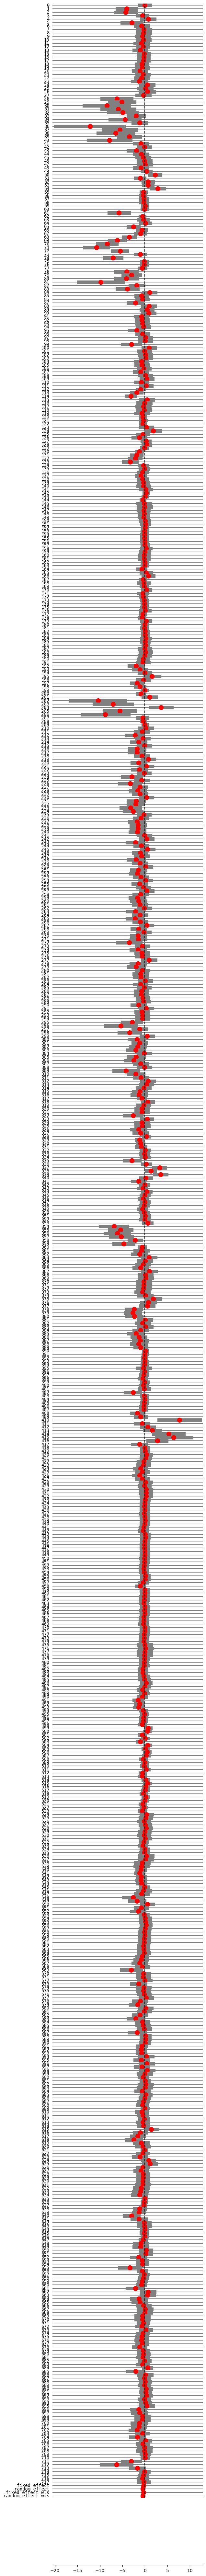

In [120]:
import statsmodels.stats.meta_analysis as sma
# drop nas (shouldn't be necessary)
results_ph = results_ph.dropna(subset=['hedges_g', 'hedges_g_var'])
res = sma.combine_effects(pd.to_numeric(results_ph.hedges_g, errors="coerce"), pd.to_numeric(results_ph.hedges_g_var, errors="coerce"), method_re="chi2", use_t=True, row_names=results_ph.ID)

print(res.summary_frame())
# fig, ax = plt.subplots(figsize=(3,40))
fig = res.plot_forest()
fig.set_figheight(100)
fig.set_figwidth(6)
# plot a line at 0
plt.axvline(x=0, color='k', linestyle='--')

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.000000  0.571250 -1.119630  1.119630  0.000984  0.001452
1                 -4.067009  1.073944 -6.171900 -1.962118  0.000278  0.000894
2                 -4.259911  1.110706 -6.436856 -2.082966  0.000260  0.000862
3                 -0.572777  0.585432 -1.720202  0.574648  0.000937  0.001434
4                  0.730749  0.717148 -0.674834  2.136333  0.000624  0.001271
...                     ...       ...       ...       ...       ...       ...
717               -0.223059  0.617399 -1.433139  0.987021  0.000842  0.001394
fixed effect      -0.311154  0.017916 -0.346269 -0.276038  1.000000       NaN
random effect     -0.519677  0.043883 -0.605686 -0.433668       NaN  1.000000
fixed effect wls  -0.311154  0.028254 -0.366531 -0.255777  1.000000       NaN
random effect wls -0.519677  0.043883 -0.605686 -0.433668       NaN  1.000000

[721 rows x 6 columns]


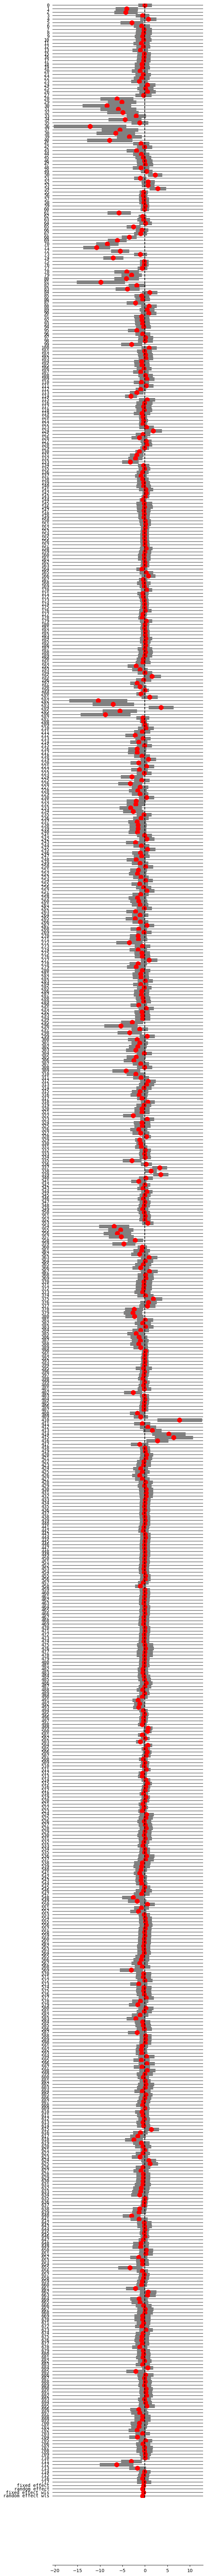

In [118]:
import statsmodels.stats.meta_analysis as sma


# drop nas (shouldn't be necessary)
results_ph = results_ph.dropna(subset=['hedges_g', 'hedges_g_var'])
res = sma.combine_effects(pd.to_numeric(results_ph.hedges_g, errors="coerce"), pd.to_numeric(results_ph.hedges_g_var, errors="coerce"), method_re="iterated", use_t=False, row_names=results_ph.ID)

print(res.summary_frame())
# fig, ax = plt.subplots(figsize=(3,40))
fig = res.plot_forest()
fig.set_figheight(100)
fig.set_figwidth(6)
# plot a line at 0
plt.axvline(x=0, color='k', linestyle='--')

## Additional

In [46]:
### merge results with climatology data
matched_df = results_df.set_index('doi').merge(climatology_df, left_index=True, right_index=True)   # TODO: drops ~100 rows for some reason

# define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['treatment']]]
    if row['treatment'] in clim_var_map else np.nan,
    axis=1
)
# assign which variable to use for delta calculation
matched_df['delta_var'] = matched_df.apply(
    lambda row: row['delta_t'] if row['treatment'] == 't_in' else row['delta_pH'],
    axis=1)

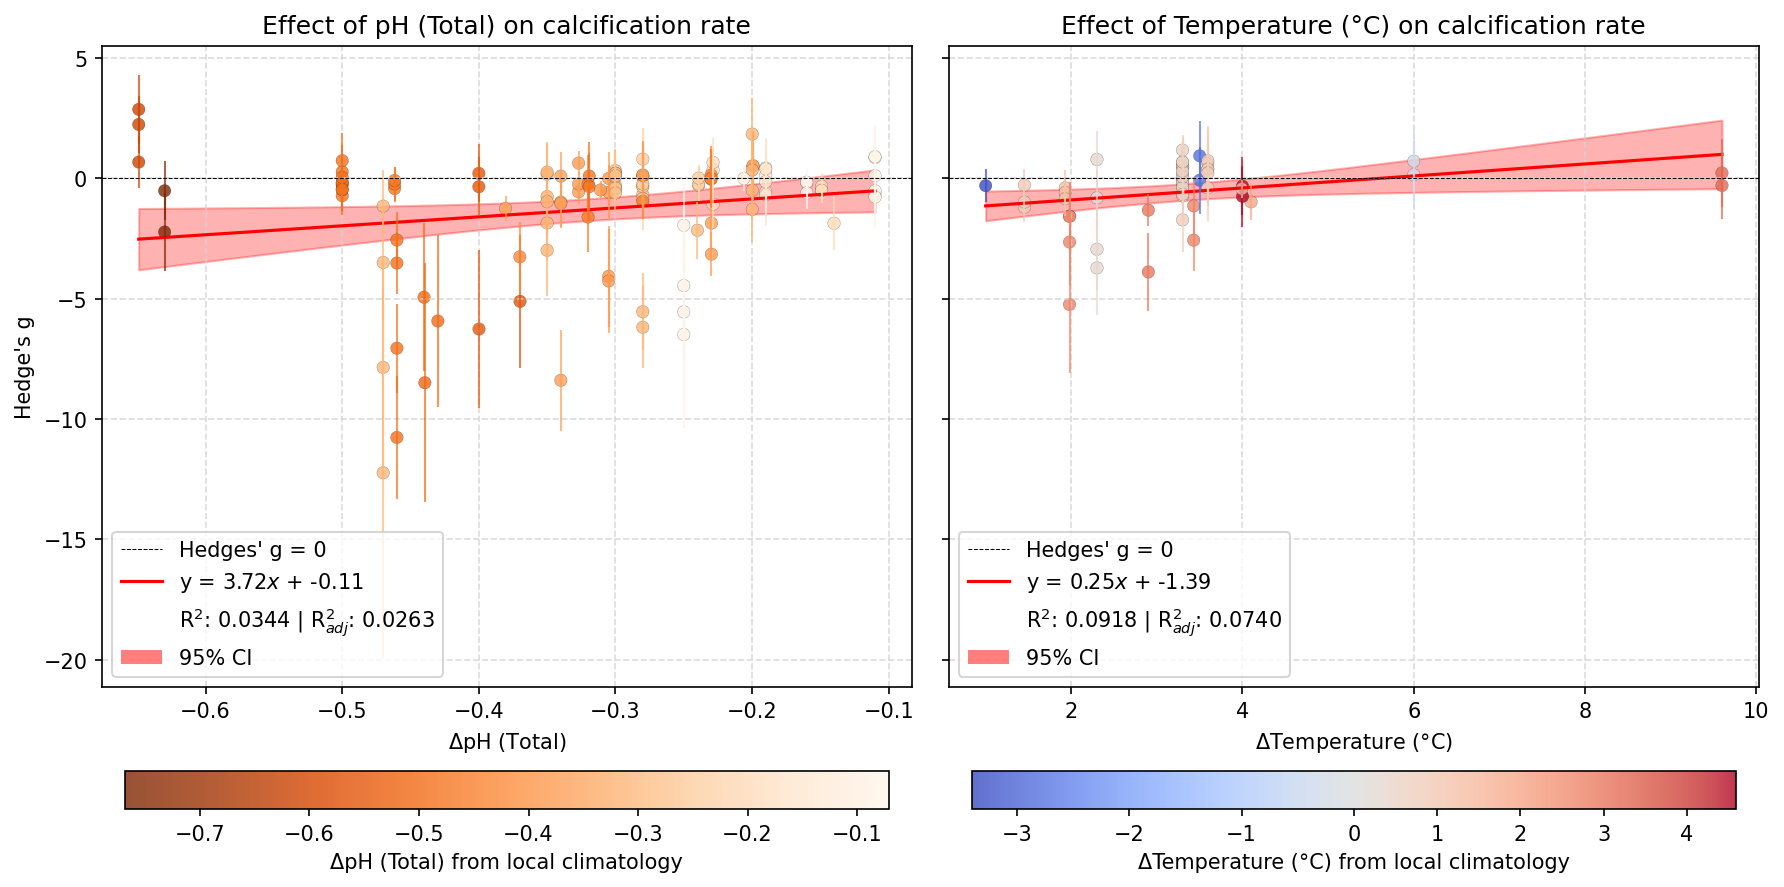

In [47]:
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

plot_results = matched_df
plot_results = plot_results.dropna(subset=['delta_t', 'delta_pH', 'hedges_g'])

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])   # remove NaNs and infinities
    delta_var = subset_df['delta_t'] if var == 't_in' else subset_df['delta_pH']
    
    # plot regression line
    summary_stats = plotting.simple_regplot(delta_var, subset_df['hedges_g'], ax=ax, line_kws={"color": "r"}, ci_kws={"color": "red"})
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.Oranges_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm=mcolors.TwoSlopeNorm(vmin=subset_df['clim_delta'].min(), vcenter=0, vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]

    # plot error bars with delta climatology colours
    for i, (x, y, yerr, color) in enumerate(zip(delta_var, subset_df['hedges_g'], 
                                            (subset_df['hedges_g'] - subset_df['hedges_g_l']).values, 
                                            colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='none', ecolor=color, alpha=0.7, lw=1)
    
    scatter = ax.scatter(delta_var, subset_df['hedges_g'],
                         c=subset_df['clim_delta'], cmap=cmap, norm=norm,
                         alpha=0.8, lw=0.1, edgecolor='black')
                         
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, pad=0.11, orientation = 'horizontal')
    cbar.set_label(f"Δ{var_name} from local climatology")

    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0), 1, 1, fc="red", edgecolor='none', alpha=0.5)
    ax.plot([], [], alpha=0, label=f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [48]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from scipy import stats
import plotly.express as px
plot_results = matched_df
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, 
                    subplot_titles=("Effect of pH (Total) on calcification rate", 
                                   "Effect of Temperature (°C) on calcification rate"))

variables = ['phtot', 't_in']
var_names = ['pH (Total)', 'Temperature (°C)']
delta_vars = ['delta_pH', 'delta_t']

# process each subplot
for i, (var, var_name, delta_var) in enumerate(zip(variables, var_names, delta_vars)):
    col = i+1  # plotly uses 1-indexed columns for some reason
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    # data cleaning (NaNs and infinities)
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])
    # relevant variable    
    x_values = subset_df[delta_var]
    y_values = subset_df['hedges_g']
    y_error = subset_df['hedges_g'] - subset_df['hedges_g_l']
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]
    
    # regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
    r_squared = r_value**2
    adjusted_r_squared = 1 - ((1 - r_squared) * (len(x_values) - 1) / (len(x_values) - 2))
    x_reg = np.linspace(min(x_values), max(x_values), 100)
    y_reg = slope * x_reg + intercept

    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg,
            mode='lines',
            line=dict(color='red'),
            name=f'y = {slope:.2f}x + {intercept:.2f}'
        ),
        row=1, col=col
    )
    # add approximated confidence interval
    ci = 1.96 * std_err  # 95% CI
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg + ci,
            mode='lines',
            line=dict(width=0),
            showlegend=False
        ),
        row=1, col=col
    )    
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg - ci,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(255, 0, 0, 0.2)',
            name='95% CI'
        ),
        row=1, col=col
    )
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # add scatter points with error bars and hover text
    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=y_values,
            mode='markers',
            marker=dict(
                # color=colors[0:10],  # Use the colors list generated from climatology delta
                # colors= cmap,
                size=10, 
                line=dict(width=1, color='black'), 
                opacity=0.5
            ),
            # color_continuous_scale='coolwarm',
            error_y=dict(
                type='data',
                array=y_error,
                visible=True,
                color='blue',
                thickness=1,
                width=5
            ),
            name='Data points',
            hovertemplate=
            f'Δ{var_name}: %{{x}}<br>' +
            'Hedges\' g: %{y}<br>' +
            'Treatment Calcification: %{customdata[0]:.4f}<br>' +
            'Control Calcification: %{customdata[1]:.4f}<br>' +
            'DOI: %{text}<extra></extra>',
            text=subset_df.index,
            customdata=subset_df[['treatment_calcification', 'control_calcification']]
        ),
        row=1, col=col
    )
    # add horizontal line at y=0 (Hedges g = 0)
    fig.add_trace(
        go.Scatter(
            x=[min(x_values), max(x_values)],
            y=[0, 0],
            mode='lines',
            line=dict(color='black', width=1, dash='dash'),
            name="Hedges' g = 0"
        ),
        row=1, col=col
    )


fig.update_layout(
    width=1200,
    height=600,
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-.2,
        xanchor="right",
        x=1
    )
)

# Update x and y axis labels
for i in range(2):
    fig.update_xaxes(title_text=f"Δ{var_names[i]}", row=1, col=i+1, gridcolor='lightgrey')

fig.update_yaxes(title_text="Hedges' g", row=1, col=1, gridcolor='lightgrey')

# Show the figure
fig.show()

# Main analysis


### Basic plotting of result

NameError: name 'subset' is not defined

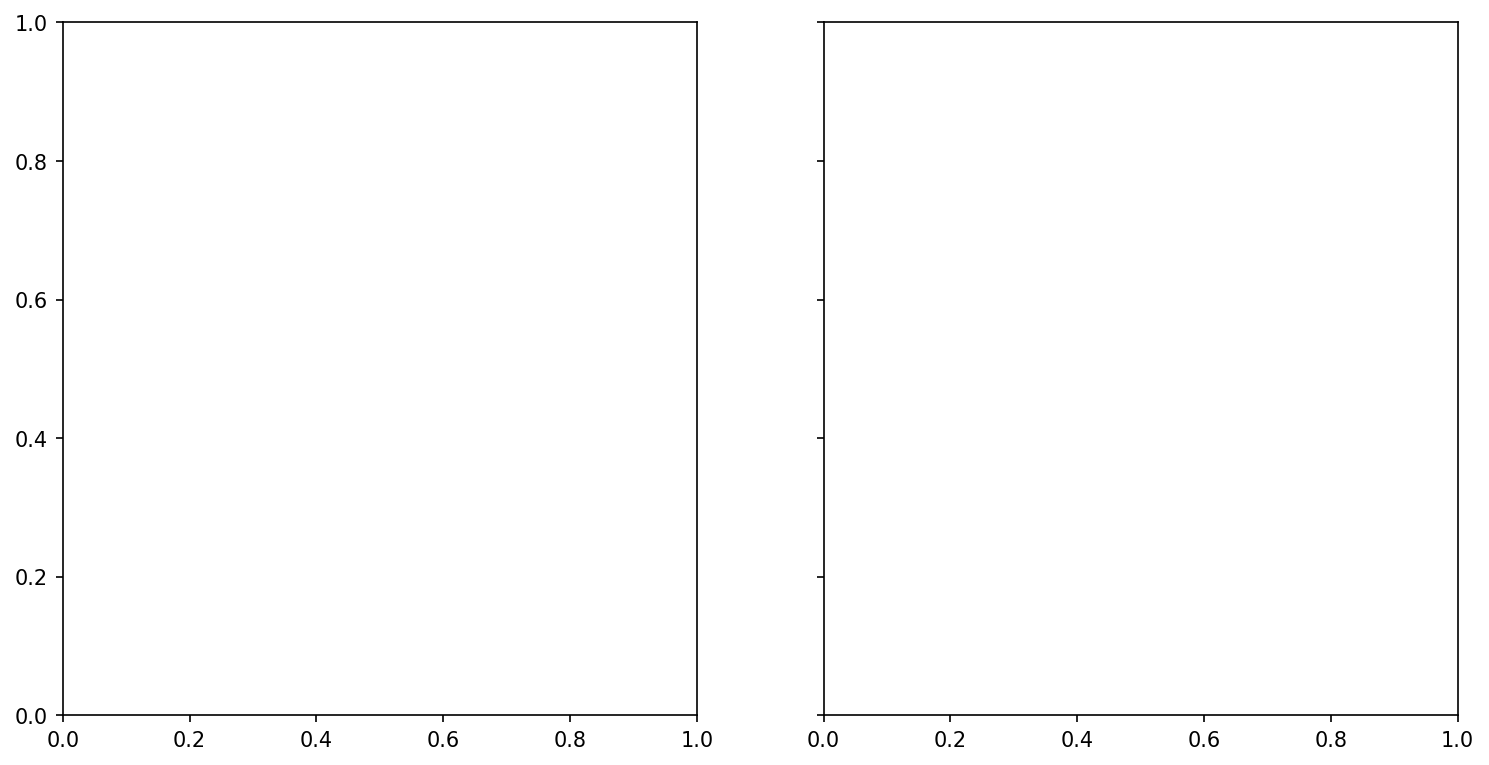

In [49]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

# plot_results = results_df[results_df.multi_var==1]
plot_results = results_df

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    # subset = results_df[results_df.multi_var==1][results_df[results_df.multi_var==1]['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    # plot regression line
    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # # Plot error bars **matching scatter point colors**
    # for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
    #                                             (subset['hedges_g'] - subset['hg_ci_l']).values, 
    #                                             colors)):
    #     ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c="blue",
                         alpha=0.8, lw=0.1, edgecolor='black')

    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [ ]:
# Match by DOI the Hedges' g results with the climatology data
# matched_df = results_df.join(climatology_df, how="left", rsuffix="_clim")
matched_df = results_df.merge(climatology_df, left_index=True, right_index=True)

# Define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# Calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['variable']]]
    if row['variable'] in clim_var_map else np.nan,
    axis=1
)

In [ ]:
# set(climatology_df.index) - set(carb_df['doi'].unique())
set(climatology_df.index) - set(results_df.index)


In [ ]:
print(len(matched_df))
print(matched_df.clim_delta.isna().sum())

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    cmap = cm.coolwarm
    norm = mcolors.Normalize(vmin=subset['clim_delta'].min(), vmax=subset['clim_delta'].max())
    colors = [cmap(norm(val)) for val in subset['clim_delta']]

    # Plot error bars **matching scatter point colors**
    for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
                                                (subset['hedges_g'] - subset['hg_ci_l']).values, 
                                                colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c=subset['clim_delta'], cmap=cmap, norm=norm, 
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

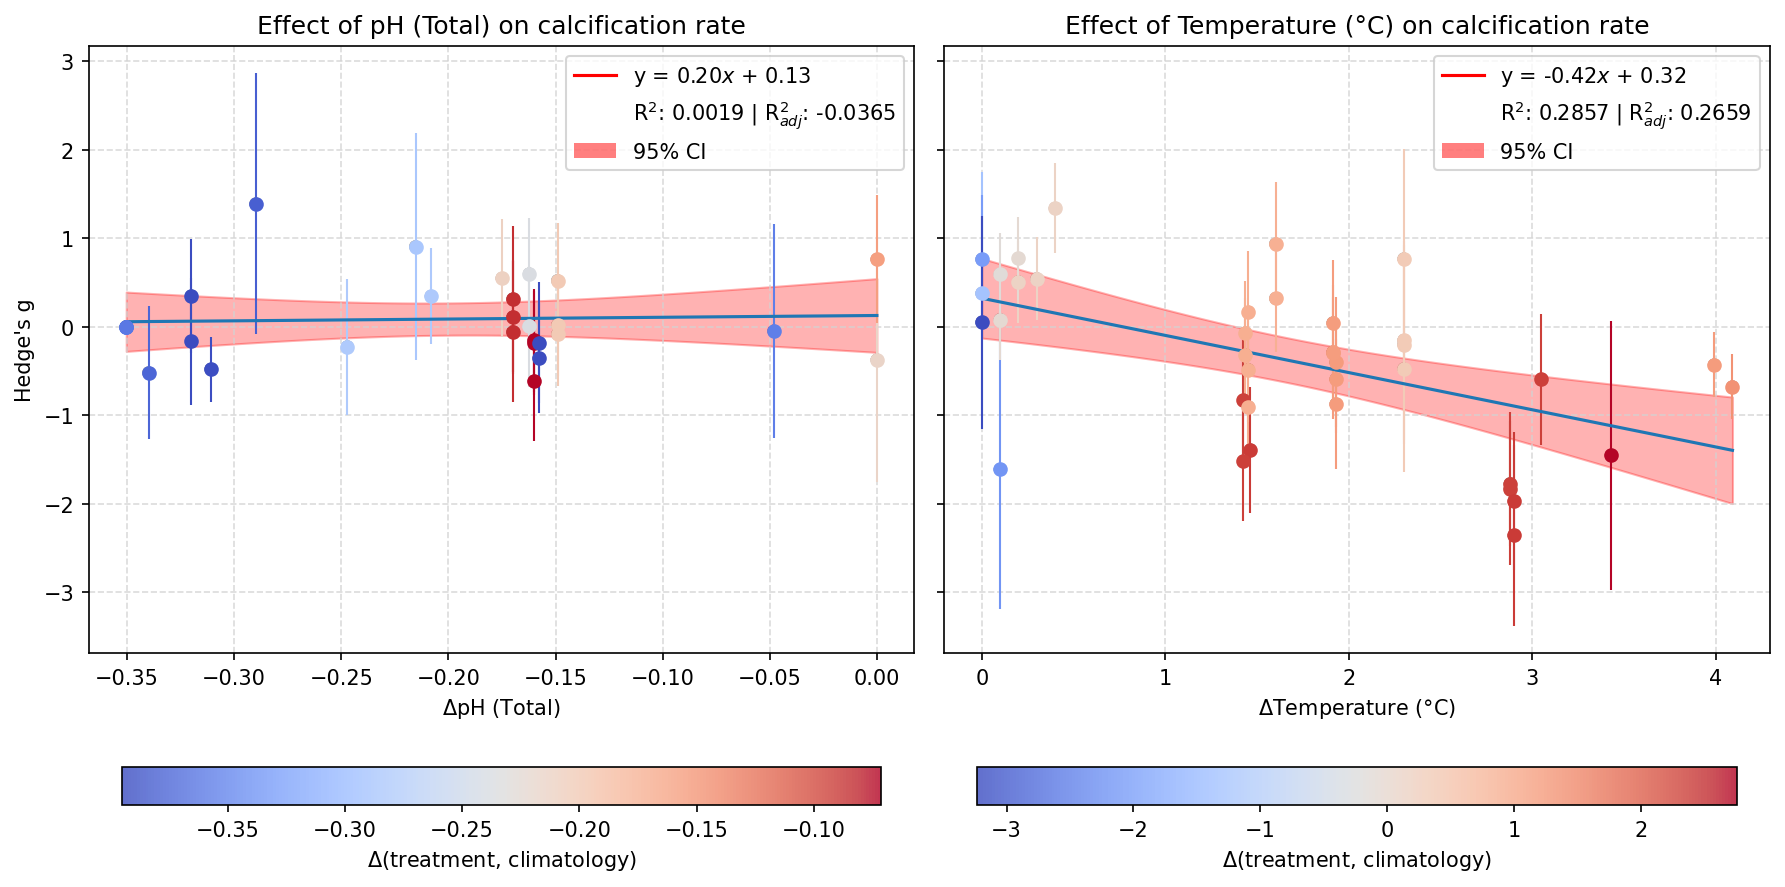

In [ ]:
sel_cols = ['species_types', 'treatment_group', 'phtot', 't_in', 'irr', 'calcification', 'calcification_sd', 'n']
study_df[sel_cols]

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])        # remove any rows containing nans
    


    # Scatter plot with color mapping
    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c='blue',
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend

    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()